In [4]:
%load_ext autoreload
%autoreload 2 
from vpot.calc import myMolecule, sphericalGrid, blockGrid, pointGrid
from vpot.calc.potential import vpot,vBpot, vpotANC
from vpot.calc import DFTGroundState
from matplotlib import pyplot as plt
from scipy.special import erf

import psi4
import numpy as np
import logging,time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
b = {1 : -3.6442293856e-01, 2 : -1.9653418982e-01, 3 : -1.3433604753e-01, 4 : -1.0200558466e-01,
     5 : -8.2208091118e-02, 6 : -6.8842555167e-02, 7 : -5.9213652850e-02, 8 : -5.1947028250e-02,
     9 : -4.6268559218e-02, 10 : -4.1708913494e-02, 11 : -3.7967227308e-02, 12 : -3.4841573775e-02}

def V(a, b, r):
    h_prime_term = h_prime(a, b, r)
    h_double_prime_term = h_double_prime(a, b, r)
    v = -0.5 + (h_prime_term / r) + (h_prime_term**2 / 2) + (h_double_prime_term / 2)
    return v

def V_Z(Z, a, b, r):
    """
    Returns the value of the V_Z function for the given parameters.

    Parameters:
        Z (float): the value of Z
        a (float): the value of a
        b (float): the value of b
        r (float): the value of r

    Returns:
        float: the value of V_Z(Z, a, b, r) = Z^2 * V(a, b, Z*r)
    """
    return Z**2 * V(a, b, Z*r)


def h(a, b, r):
    erf_term = -r * erf(a*r)
    exp_term = b * np.exp(-a**2 * r**2)
    return erf_term + exp_term

def h_prime(a, b, r):
    erf_term = -erf(a*r)
    exp_term = -2 * ((a**2) * b + (a / np.sqrt(np.pi))) * r * np.exp(-a**2 * r**2)
    return erf_term + exp_term

def h_double_prime(a, b, r):
    exp_term = (-2 * (a**2) * b - (4 * a) / np.sqrt(np.pi) 
                + (4 * (a**4) * b + (4 * (a**3)) / np.sqrt(np.pi)) * r**2) * np.exp(-a**2 * r**2)
    return exp_term



(-10.0, 0.5)

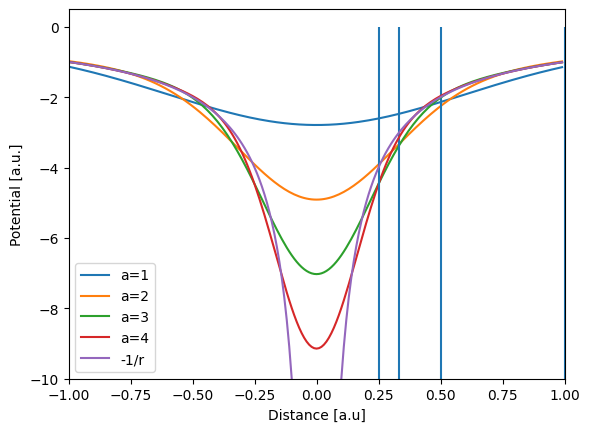

In [6]:
X = np.arange(-1.0,1.0,0.01)
Z = 1
for prec in [1,2,3,4]:
    plt.plot(X,V_Z(Z,prec,b[prec],X),label=f"a={prec}")
    plt.vlines(Z/prec,-25,0.0)
plt.plot(X,-Z/np.abs(X),label=f"-{Z}/r")
plt.legend()
plt.ylim(-Z/0.02,0)
plt.xlabel("Distance [a.u]")
plt.ylabel("Potential [a.u.]")
plt.xlim(-1.0,1.0)
plt.ylim(-10,0.5)

(-1.0, 0.0)

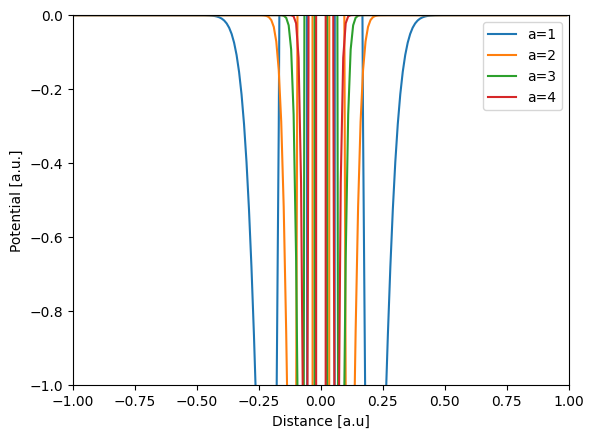

In [266]:
X = np.arange(-1.0,1.0,0.01)
Z = 8
for prec in [1,2,3,4]:
    plt.plot(X,-Z/np.abs(X) - V_Z(Z,prec,b[prec],X),label=f"a={prec}")
    plt.vlines(Z/prec,-25,0.0)
plt.legend()
plt.ylim(-Z/0.02,0)
plt.xlabel("Distance [a.u]")
plt.ylabel("Potential [a.u.]")
plt.xlim(-1.0,1.0)
plt.ylim(-1.0,0.0)

In [7]:
def basisExp(Ds,exps,Ls,r):
    """
    This is the basis set expansion of size
    len(Ds)==len(exps)==len(Ls)
    """
    size = len(r)
    Y = np.zeros(size)
    
    for d,exp,l in zip(Ds,exps,Ls):
        Y += cgp(d,exp,l,r)
        
    return Y
    


def cgp(D,exps,l,r):
    Y = np.zeros(len(r))
    for d,exp in zip(D,exps):
        Y += d*gp(exp,l,r)
    return Y


def gp(exp,l,r):
    P = r**l
    N = 0
    if l==0:
        Ns = 1/np.sqrt(np.sqrt(2*np.pi)/(2*np.sqrt(exp)))
        N = Ns
    elif l==1:
        Np = 1/np.sqrt((np.sqrt(2)*np.sqrt(np.pi))/(8*exp**(3./2.)))
        N= Np
        
    elif l==2:
        Nd = 1/np.sqrt((3*np.sqrt(2)*np.sqrt(np.pi)/(32*exp**(5/2))))
        N = Nd
    N=1
    return P*N*np.exp(-exp*r**2)


def ANC(Atoms,prec,X):
    V = 0.0 
    for za,xa in Atoms:
        V += V_Z(za,prec,b[prec],X-xa)
    return V

(-5.0, 0.5)

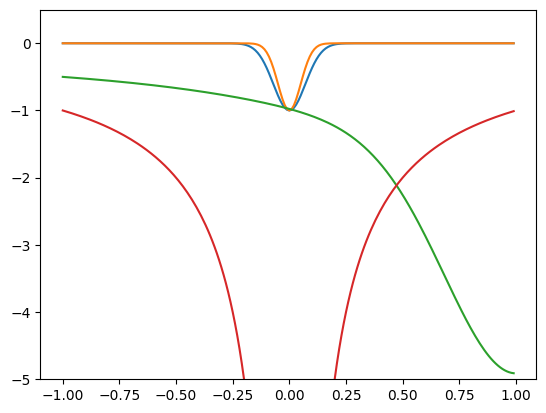

In [8]:
plt.plot(X,-gp(100,0,X))
plt.plot(X,-cgp([1],[200],0,X))
#plt.plot(X,-cgp([100],[2000],X))
plt.plot(X,ANC([(1.0,1.0)],2,X))
plt.plot(X,-1/np.abs(X))
plt.ylim(-5,0.5)

initX: [[  25.00215916 -283.90578109]
 [  32.37368065 -283.90578109]
 [  27.67219687 -283.90578109]
 [  28.89716658 -283.90578109]
 [  22.84332743 -283.90578109]
 [  25.75075021 -283.90578109]
 [  28.87518074 -283.90578109]
 [  27.09353651 -283.90578109]
 [  23.08404141 -283.90578109]
 [  18.78489761 -283.90578109]
 [  23.06599663 -283.90578109]
 [  20.85257867 -283.90578109]
 [  25.76291675 -283.90578109]
 [  17.2017493  -283.90578109]
 [  20.74657139 -283.90578109]]
SUCCESS? : False
  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 7.882926179248017
        x: [ 1.928e+02 -2.312e+02 ...  4.060e+01 -1.111e+03]
      nit: 372
      jac: [ 5.332e-03  5.007e-02 ...  2.310e-03 -2.075e-04]
     nfev: 15004
     njev: 484
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>


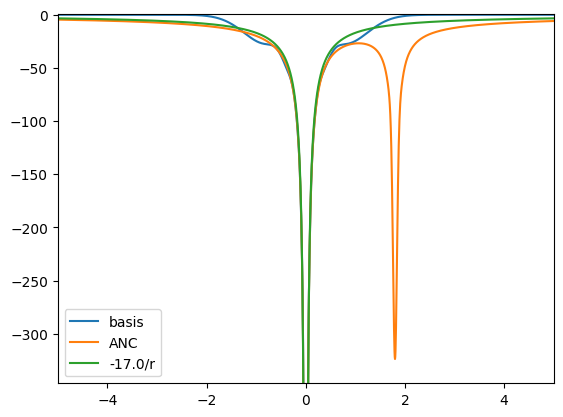

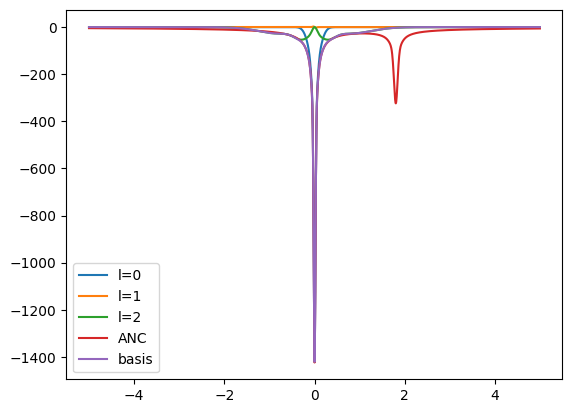

For Z=17.0 and a=2
[0,
(192.7589617300659,-0.769014157382904),
(1718.6903001934058,-1.816603989951324),
(1004.4464991067972,-0.6493768031628483),
(1231.4126491547422,-0.9769640186443883),
(33.55908857072112,-0.5159269051734492),
],
[1,
(762.7220116963495,-51.48330676825529),
(755.7881203396306,-52.59483156475664),
(759.9485968299967,-52.45474268737302),
(768.194079722314,-51.532550511392735),
(776.1097762155607,-51.66248123327628),
],
[2,
(81.17045348790117,-34.1355812305694),
(11.25291463476282,-23.438126333520163),
(179.95084764454066,-29.700970714530005),
(1.4945248029492326,-1.9995803873196314),
(40.59834175245852,-20.189215377282373),
],


In [68]:
from scipy.optimize import minimize

def DIFF(x0,Atoms,prec,L,l,X):
    
    D    =  x0.reshape(-1,2)[:,1].reshape(-1,L)
    exps =  x0.reshape(-1,2)[:,0].reshape(-1,L)
    Ls = l
    
    Xopt = np.arange(-1.2,1.2,0.005)
    Y1 = ANC(Atoms,prec,Xopt)
    Y2 = basisExp(D,exps,Ls,Xopt)
    
    return np.sum(np.square(Y1-Y2))/len(Xopt)



def plotInitialSetup(Atoms,X):
    plt.plot(X,ANC(Atoms,prec,X))
    
# Atoms are give as [(Za,Xa),(Zb,Xb)]

"""
The idea is now to input an s,p and a d function,
each is contracted with 3 expoenents and 3 contraction coefficients

"""

Atoms = [(17.0,0.0),(8.0,1.8)]


L = 5
prec = 2

Z = Atoms[0][0]
Ls= [0,1,2]
basisSize = len(Ls)
xlen = 5.0


initX = np.zeros(basisSize*2*L).reshape(-1,2)
initX[:,0] = np.sqrt((3.80564869305321*Z**2)*np.random.rand(basisSize*L))
initX[:,1] = -(4.91186472473308*Z**2)/L

initX = initX.flatten()
bounds = [(0.1,100000.0) if (c%2==0) else (None,None) for c,x in enumerate(initX) ]



"""
for i in range(basisSize):
    initX[(2*i)*L:(2*i+1)*(L)] = (-(4.91186472473308*Z**2)/L)*10**i
    for c in range((2*i+1)*(L),(2*i+2)*L):
        initX[c] = (3.80564869305321*Z**2)*(np.random.rand(1)+0.5)


Y0 = 3.0*Z**2*prec**2*b[prec] - 3.38513750128654*Z**2*prec - 0.5*Z**2
"""

    
print(f"initX: {initX.reshape(-1,2)}")

X = np.arange(-xlen,xlen,0.005)

results = minimize(DIFF,initX,args=(Atoms,prec,L,Ls,X),bounds=bounds)
print(f"SUCCESS? : {results['success']}")
print(results)

D    =  results["x"].reshape(-1,2)[:,1].reshape(-1,L)
exps =  results["x"].reshape(-1,2)[:,0].reshape(-1,L)


plt.plot(X,basisExp(D,exps,Ls,X),label="basis")
plt.plot(X,ANC(Atoms,prec,X),label="ANC")
plt.plot(X,-Z/np.abs(X),label=f"-{Z}/r")
plt.ylim(Y0,1.0)
plt.xlim(-xlen,xlen)
plt.legend()
plt.show()
results

C = []

for d,exp,l in zip(D,exps,Ls):
    N = 1./np.sqrt(np.trapz(cgp(d,exp,l,X)*cgp(d,exp,l,X),X))
    C.append(1/N)
    d *=N

YBasis = np.zeros(len(X))
for c,d,exp,l in zip(C,D,exps,Ls):
    plt.plot(X,c*cgp(d,exp,l,X), label=f"l={l}")
    YBasis += c*cgp(d,exp,l,X)
    
plt.plot(X,ANC(Atoms,prec,X),label="ANC")
plt.plot(X,YBasis,label="basis")

plt.legend()

plt.show()


print(f"For Z={Z} and a={prec}")

for l,d,exp in zip(Ls,D,exps):
    print(f"[{l},",)
    for i,j in zip(d,exp):
        print(f"({j},{i}),")
    print("],")
    
     




# Try with p functions

initX: [-4.91186472 -4.91186472 -4.91186472  1.99619997  5.2215742   4.49047686]
SUCCESS? : True


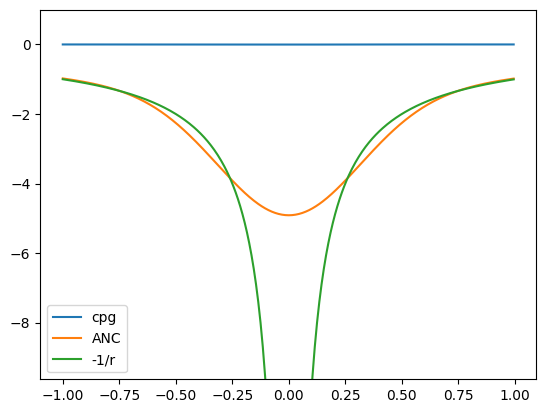

[ 0.10633265 -0.11957218  0.00957   ]
[-0.66334006  0.74593281 -0.05970099]
-0.1602988601589935


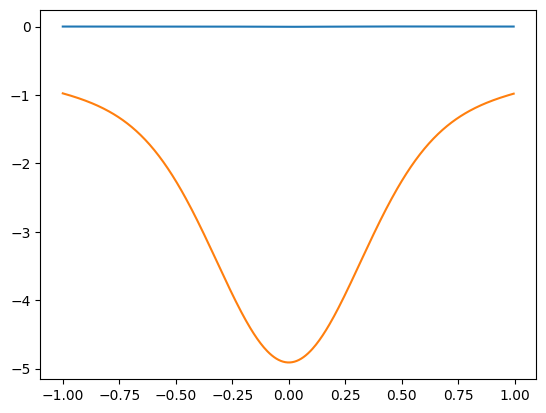

For Z=1, a=2
coeffs: [-0.66334006  0.74593281 -0.05970099]
exps:  [6.79203834 7.13181587 6.90395273]
(6.792038344415905,-0.6633400557137153),
(7.131815870715104,0.7459328137742444),
(6.90395272668907,-0.05970098676373365),


In [301]:
from scipy.optimize import minimize

def DIFF(x0,Z,prec,L,X):
    
    D    = x0[:L]
    exps = x0[L:]
    Y1 = ANC(Z,prec,X)
    Y2 = cgpp(D,exps,X)
    
    return np.sum(np.square(Y1-Y2))/len(X)

L = 3
Z = 1
prec = 2

xlen = 1.0


Y0 = 3.0*Z**2*prec**2*b[prec] - 3.38513750128654*Z**2*prec - 0.5*Z**2

initX = np.zeros(2*L)
initX[:L] = -(4.91186472473308*Z**2)

for c,i in enumerate(initX[L:]):
    initX[L+c] = (3.80564869305321*Z**2)*(np.random.rand(1)+0.5)
    
print(f"initX: {initX}")

X = np.arange(-xlen,xlen,0.005)

results = minimize(DIFF,initX,args=(Z,prec,L,X))
print(f"SUCCESS? : {results['success']}")

plt.plot(X,cgp(results["x"][:L],results["x"][L:],X),label="cpg")
plt.plot(X,ANC(Z,prec,X),label="ANC")
plt.plot(X,-Z/np.abs(X),label=f"-{Z}/r")
plt.ylim(Y0,1.0)
plt.legend()
plt.show()
results

coeffs = np.array(results["x"][:L])
exps   = np.array(results["x"][L:])
print(coeffs)
np.linalg.norm(coeffs)


prefac = -np.linalg.norm(coeffs)
coeffs /= -np.linalg.norm(coeffs)

print(coeffs)
print(prefac)

plt.plot(X,prefac*cgp(coeffs,exps,X))
plt.plot(X,ANC(Z,prec,X),label="ANC")

plt.show()

print(f"For Z={Z}, a={prec}")

print(f"coeffs: {coeffs}")
print(f"exps:  {exps}")

for e,c in zip(exps,coeffs):
    print(f"({e},{c}),")